In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys, os, glob
sys.path.append('/code/tools')
sys.path.append('/code/tools/scoring')
from plif import PlifScore
from misc import vina_pdbqt_to_sdf
from ui.file_widgets import DockButtons, PathSelector, InputBoxSet

# Scoring vina results: PLIF (protein-ligand interaction fingerprint) against reference

---

### 1. Convert pdbqt files to sdf files 

---

input directory = the place where all of the pdbqt files from a docking run are  
output directory = where to write the sdfs out to 

In [4]:
iconv = InputBoxSet(tlabel='input dir:')
iconv.render()
oconv = InputBoxSet(tlabel='output dir:')
oconv.render()

A Jupyter Widget

In [5]:
input_dir = iconv.inbox.value
output_dir = oconv.inbox.value

infiles = glob.glob(os.path.join(input_dir, '*.pdbqt'))

[vina_pdbqt_to_sdf(ifile=i, output=os.path.join(output_dirut_dir, i.split('/')[-1].replace('.pdbqt', 'sdf'))) for i in infiles]

[]

---
### 2. Select some input files for the PLIF scoring
---

#### 2.1.  Select the protein and reference ligand: 
*(N.B. run the next 2 cells to show the file dialogues)*
1. click on the arrow in the dropdown box at the top
2. select the relevant file in the dialogue 
3. click the button next to either protein, query ligands or reference to set the file

---

#### 2.2.  Select the query molecules to score against the reference ligand:

**There are two options here:** 

1. Use one file to specify which ligands to score: use the buttons as described above
2. Specify a directory of sdf files of multiple files of ligands to score: type the directory to search in the 'multiple dir' input box, and click 'set'


In [6]:
p = PathSelector(start_dir=os.getcwd())
display(p.accord)

b = DockButtons(path_selector=p)
b.render_buttons()

A Jupyter Widget

A Jupyter Widget

In [7]:
pdb_file = b.pdb_button.description
ligands_file = b.lig_button.description
ref_file = b.ref_button.description

In [8]:
pdb_file

'/data/docking/XX02KALRNA-x1376_1/XX02KALRNA-x1376_1_prepared.pdb'

In [9]:
inp = InputBoxSet(tlabel='multiple dir:')
inp.render()

A Jupyter Widget

/data/docking/XX02KALRNA-x1376_1/docked/sdf


---
### 3. run the PLIF scoring
---

This returns: 

**For one file:** a dataframe with the scores in  
**For multiple files:** a list of dataframes with the scores in

You can also specify not to write the scores back out to the input sdf files by changing ```write=True``` to ```write=False``` in the ```plif.score_conformers()``` functions below

In [ ]:
if os.path.isdir(inp.inbox.value):
    files = glob.glob(os.path.join(inp.inbox.value, '*.sdf'))
else:
    files = [ligands_file]
    
plif = PlifScore(protein_pdb=pdb_file, 
                 reference_file=ref_file)

if len(files)==1:
    df = plif.score_conformers(file=ligands_file, write=True, score_col='PLIF_SCORE')
    
else:
    df_list = []
    for f in files:
        df = plif.score_conformers(file=f, write=True, score_col='PLIF_SCORE')
        df_list.append(df)

,ID,MODEL,REMARK,RMSD_LB,RMSD_UB,ROMol,SCORE,TORSDO,PLIF_SCORE
0,EN300-52827,1,VINA RESULT: -6.0 0.000 0.000\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,0.000,0.000,,-6.0,F 2,0.2
1,EN300-52827,2,VINA RESULT: -5.6 0.932 1.406\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,0.932,1.406,,-5.6,F 2,0.25
2,EN300-52827,3,VINA RESULT: -5.2 1.451 1.724\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,1.451,1.724,,-5.2,F 2,0.5
3,EN300-52827,4,VINA RESULT: -5.0 2.032 2.133\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,2.032,2.133,,-5.0,F 2,0.2
4,EN300-52827,5,VINA RESULT: -4.9 9.207 9.421\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,9.207,9.421,,-4.9,F 2,0.0
5,EN300-52827,6,VINA RESULT: -4.7 2.383 6.342\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,2.383,6.342,,-4.7,F 2,0.17
6,EN300-52827,7,VINA RESULT: -4.6 4.817 5.374\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,4.817,5.374,,-4.6,F 2,0.25
7,EN300-52827,8,VINA RESULT: -4.4 6.773 8.988\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,6.773,8.988,,-4.4,F 2,0.0
8,EN300-52827,9,VINA RESULT: -4.4 7.792 8.266\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,7.792,8.266,,-4.4,F 2,0.0
9,EN300-52827,10,VINA RESULT: -4.4 3.998 6.085\n Name = EN300-52827\n 2 active torsions:\n status: ('A' for Active; 'I' for Inactive)\n 1 A between atoms: N_10 and C_11\n 2 A between atoms: C_11 and C_12\n x y z vdW Elec q Type\n _______ _______ _______ _____ _____ ______ ____,3.998,6.085,,-4.4,F 2,0.0

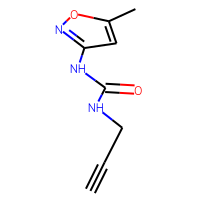
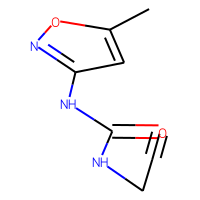
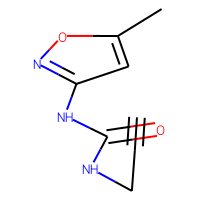
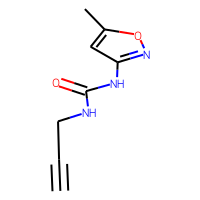
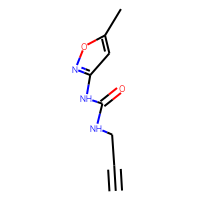
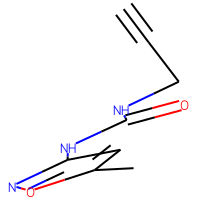
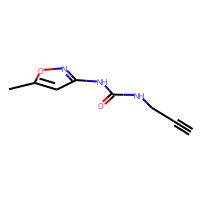
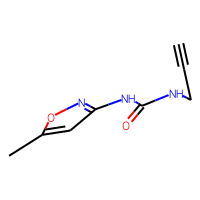
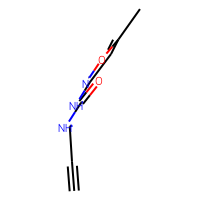
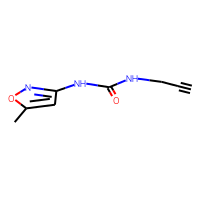
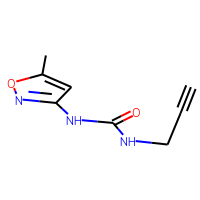
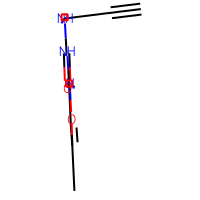
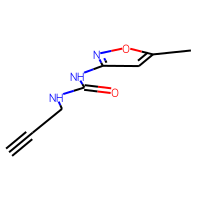
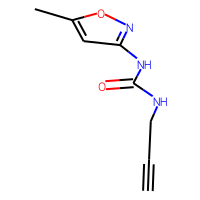
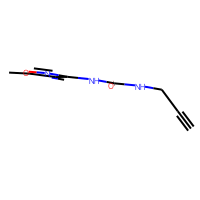
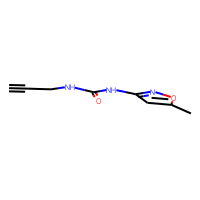
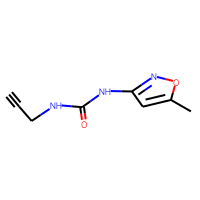
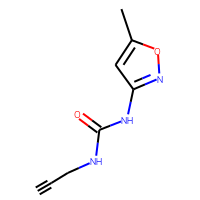
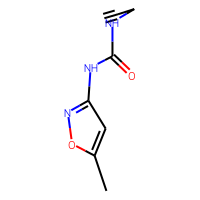
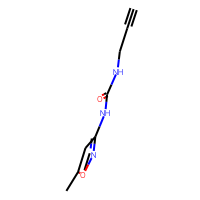

In [11]:
df